Here we explore the bias-variance trade-off.

## Global modules import

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import json
import numpy as np
import random as rnd
import sys
import torch

from sklearn.model_selection import train_test_split
from operator import itemgetter

## Local modules import

In [25]:
sys.path.append("../..")

## Loading data

In [26]:
from data_loading import create_word_lists, tidy_sentence_length

In [27]:
with open("../../data/corpus_data.json") as json_file:
    data = json.load(json_file)
data = data["records"]

In [28]:
human_transcripts = [entry["human_transcript"] for entry in data]
stt_transcripts = [entry["stt_transcript"] for entry in data]

In [29]:
human_words, stt_words, word_labels, word_grams, word_sems = create_word_lists(data)

In [30]:
stt_transcripts, stt_words, word_labels, word_grams, word_sems = tidy_sentence_length(
    stt_transcripts, stt_words, word_labels, word_grams, word_sems
)

# PIPELINE START
---

## Train-test split

In [31]:
max_length = max(map(len, word_labels))
padded_labels = [row + [False] * (max_length - len(row)) for row in word_labels]
padded_labels = np.array(padded_labels)
stat_labels = np.any(padded_labels, axis=1)

In [32]:
indices = list(range(len(stt_transcripts)))
tr_indices, te_indices = train_test_split(
    indices, test_size=0.2, random_state=0, shuffle=True, stratify=stat_labels
)

In [33]:
extract_train = itemgetter(*tr_indices)
extract_test = itemgetter(*te_indices)

In [34]:
tr_stt_transcripts = extract_train(stt_transcripts)
tr_stt_words = extract_train(stt_words)

tr_word_labels = extract_train(word_labels)
tr_word_grams = extract_train(word_grams)
tr_word_sems = extract_train(word_sems)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

te_stt_transcripts = extract_test(stt_transcripts)
te_stt_words = extract_test(stt_words)

te_word_labels = extract_test(word_labels)
te_word_grams = extract_test(word_grams)
te_word_sems = extract_test(word_sems)

## BERT part

In [35]:
import torch
from transformers import BertTokenizer, BertModel

In [36]:
from bert_encoder import encode_sentence

In [37]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model_bert = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
model_bert.eval();

In [38]:
tr_stt_vectors = []
te_stt_vectors = []

In [39]:
for sentence, words in zip(tr_stt_transcripts, tr_stt_words):
    tr_stt_vectors.append(encode_sentence(sentence, words, model_bert, tokenizer))

In [40]:
for sentence, words in zip(te_stt_transcripts, te_stt_words):
    te_stt_vectors.append(encode_sentence(sentence, words, model_bert, tokenizer))

In [41]:
tr_tensor = torch.vstack(tr_stt_vectors)
tr_label_tensor = torch.tensor(
    [int(element) for sublist in tr_word_labels for element in sublist]
)
tr_grams_tensor = torch.tensor(
    [int(element) for sublist in tr_word_grams for element in sublist]
)
tr_sems_tensor = torch.tensor(
    [int(element) for sublist in tr_word_sems for element in sublist]
)


te_tensor = torch.vstack(te_stt_vectors)
te_label_tensor = torch.tensor(
    [int(element) for sublist in te_word_labels for element in sublist]
)
te_grams_tensor = torch.tensor(
    [int(element) for sublist in te_word_grams for element in sublist]
)
te_sems_tensor = torch.tensor(
    [int(element) for sublist in te_word_sems for element in sublist]
)

## MLP part

In [118]:
import itertools
import pandas as pd

from sklearn.model_selection import StratifiedKFold

from tqdm import tqdm

import torch.nn as nn
import torch.optim as optim

In [119]:
from mlp import MLP, cross_validate_model, train_model, calc_stats

In [120]:
torch_device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

As features, we use both train and test data as our dataset is very small, and we are not training a model to be used in any unknown setting, but rather just so we can see what is the bias-variance tradeoff on our architecture.

In [121]:
best_params = (20, 1, 256, 0.0001)

features = torch.cat([tr_tensor, te_tensor], dim=0)
labels = torch.cat([tr_label_tensor, te_label_tensor], dim=0)

criterion = nn.BCELoss()
splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

We shuffle the rows of our data to ensure uniformity of German word distribution across subsets. This approach was empirically found to work well.

In [122]:
indices = torch.randperm(features.size(0))

# Shuffle the tensor rows based on the indices
features = features[indices]
labels = labels[indices]

We reuse `grid_search_data` to store the results of cross-validation on a gowing dataset.

In [123]:
grid_search_data = []

Create indices to index growing subsets of data:

In [124]:
dataset_sizes = np.linspace(0, features.shape[0], 11, dtype=int)[1:]

And check if the proportion of German words is constant across subsets:

In [125]:
for size in dataset_sizes:
    print(labels[:size].to(torch.float).mean().item())

0.031139647588133812
0.03145815059542656
0.02990744262933731
0.031056897714734077
0.030977144837379456
0.03073589690029621
0.030312063172459602
0.030073830857872963
0.030049577355384827
0.029981542378664017


Cross validate on growing subsets co obtain bias-variance tradeoff plot data:

In [126]:
for size in tqdm(dataset_sizes):
    epochs, hidden_layers, neurons_per_layer, learning_rate = best_params

    model = MLP(features.shape[1], hidden_layers, neurons_per_layer).to(torch_device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    tr_loss, tr_loss_std, te_loss, te_loss_std = cross_validate_model(
        model,
        features[:size],
        labels[:size],
        criterion,
        optimizer,
        splitter,
        n_epochs=epochs,
        num_workers=0,
        device=torch_device,
    )

    values_to_add = [size, tr_loss, tr_loss_std, te_loss, te_loss_std]

    # Add preliminary data to dataframe
    grid_search_data.append(values_to_add)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [05:11<00:00, 31.15s/it]


Create dataframe to store hyperparameter data and save it:

In [127]:
import os

In [133]:
out_path = "."
columns = ["dataset_size", "tr_loss", "tr_loss_std", "te_loss", "te_loss_std"]
gs_frame = pd.DataFrame(grid_search_data, columns=columns)
gs_frame.to_csv(os.path.join(out_path, "bias_variance_tradeoff.csv"), index=False)

Finally, create the plot:

In [139]:
from matplotlib import pyplot as plt

plt.rcParams["text.usetex"] = True

In [155]:
plt.style.use("ggplot")

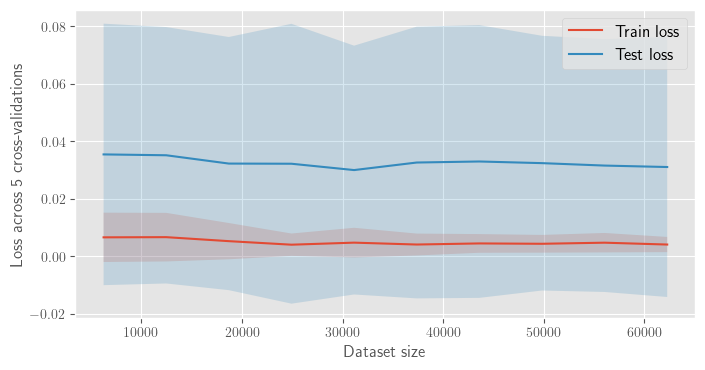

In [156]:
plt.figure(figsize=(8, 4))
plt.plot(gs_frame.dataset_size, gs_frame.tr_loss, label="Train loss")
plt.fill_between(
    gs_frame.dataset_size,
    gs_frame.tr_loss - gs_frame.tr_loss_std,
    gs_frame.tr_loss + gs_frame.tr_loss_std,
    alpha=0.2,
)

plt.plot(gs_frame.dataset_size, gs_frame.te_loss, label="Test loss")
plt.fill_between(
    gs_frame.dataset_size,
    gs_frame.te_loss - gs_frame.te_loss_std,
    gs_frame.te_loss + gs_frame.te_loss_std,
    alpha=0.2,
)

plt.xlabel("Dataset size", fontsize=12)
plt.ylabel("Loss across 5 cross-validations", fontsize=12)
plt.legend(fontsize=12)